In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.stats import norm
from numpy.fft import fft, ifft, ifftshift, fftshift

In [2]:
# Define parameters and time grid
npaths = 20000 #number of paths
T = 1 #time horizon
nsteps = 200 # number of time steps
dt = T/nsteps # time step
t = np.linspace(0,T,nsteps+1) # observation times

# Rearrange parameters (time rescaling)
C = 4
C = C * dt
G = 50
M = 60
Y = 0.7

# Compute vol(T), Schoutens page 60
var = C*(M**(Y-2)+G**(Y-2))*gamma(2-Y)
#parameters.vol = sqrt(variance*T)

# Analiticity bounds
# 0 if +\infty
lambdam = -M
lambdap = G
FLc = 2 * C * np.abs(gamma(-Y) * np.cos(np.pi * Y / 2))
FLnu = Y

In [3]:
r = 0.05
alpha = 1.1
Sigma = 0.25

def cf_log_cgmy(u, lnS, T, mu ,half_etasq, C, G, M, Y):
    
    omega = -C*gamma(-Y)*(np.power(M-1,Y)-np.power(M,Y)+np.power(G+1,Y)-np.power(G,Y ))
    print ("Omega is : %s"  % omega)
    phi_CGMY = C*T*gamma(-Y)*(np.power(M-1j*u,Y)-np.power(M,Y)+np.power(G+1j*u,Y)- np.power(G,Y))
    print ("phi_CGMY is : %s" % phi_CGMY) 
    phi = 1j*u*(lnS + (mu+omega-half_etasq)*T) + phi_CGMY - half_etasq*np.power(u,2)
    print ("phi is: %s" % phi)
    return np.exp(scale*phi)

In [4]:
## Monte Carlo
#Compute the increments of the gamma process
dG = np.random.gamma(dt/kappa,kappa,(nsteps,npaths))

# Compute the increments of the ABM on the gamma random clock
dX = mu*dG + sigma*np.random.randn(nsteps,npaths)*np.sqrt(dG)

# Accumulate the increments
X = np.vstack((np.zeros((1,npaths)), np.cumsum(dX, axis=0)))

## Expected, mean and sample path
plt.figure(1)
EX = mu*t # expected path
plt.plot(t,EX,'green',lw=2, label='Expected path')
plt.plot(t,np.mean(X,axis=1),color='r', linestyle='dotted', lw=3, label='Mean path')
plt.plot(t,X[:,::1000], alpha=0.6)
plt.legend(loc=0)
plt.xlabel('t')
plt.ylabel('X')
plt.xlim(-0.01,T)
plt.tight_layout()
plt.title('Paths of a CGMY Process dX(t) = $\mu$dG(t) + $\sigma$dW(G(t))')

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_97993/1574994019.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Paths of a CGMY Process dX(t) = $\mu$dG(t) + $\sigma$dW(G(t))')
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_97993/1574994019.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Paths of a CGMY Process dX(t) = $\mu$dG(t) + $\sigma$dW(G(t))')


NameError: name 'kappa' is not defined

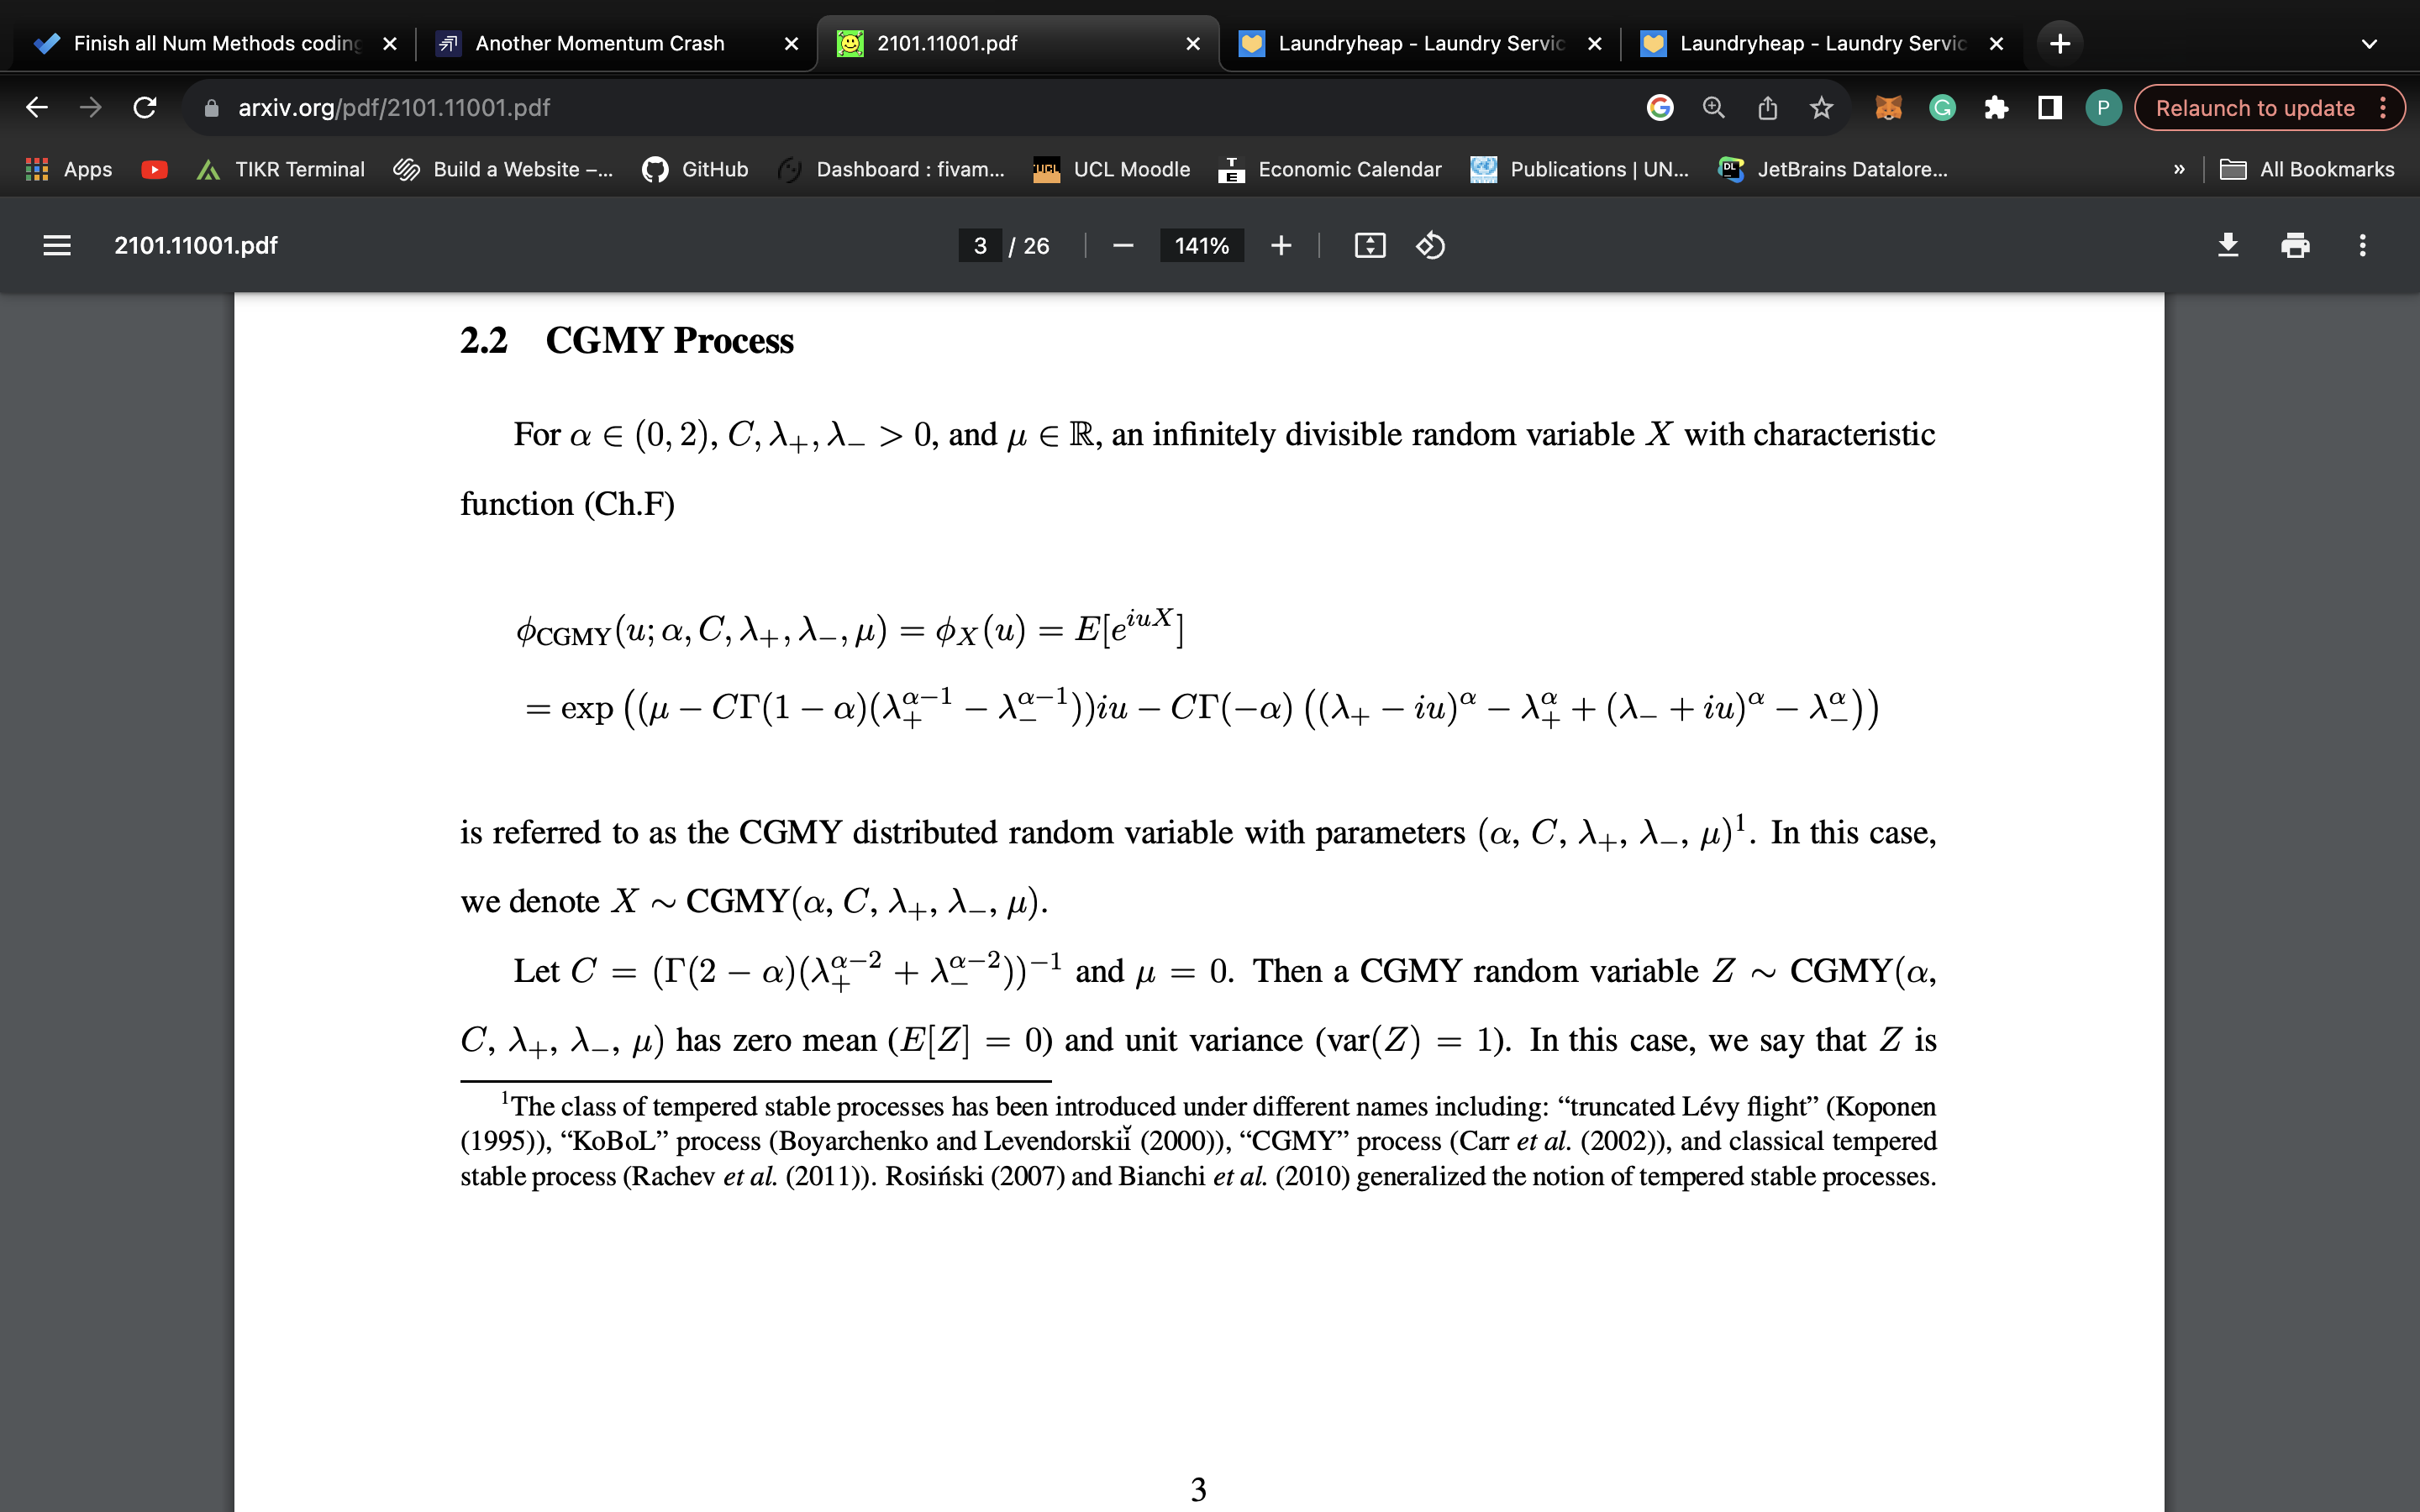

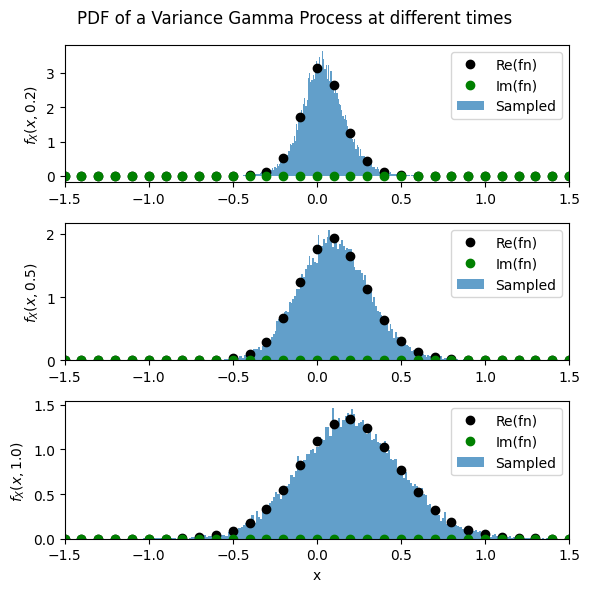

In [ ]:
# Probability density function at different times
# fig, ax = plt.subplots(3,1, figsize=(6,6))
# for i,time in enumerate([40,100,-1]):
#     ax[i].hist(X[time,:],density=True,bins=nsteps, alpha=0.7)
#     ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
#     ax[i].set_xlim(min(X[time,:]), max(X[time,:]))
# plt.suptitle('PDF of a Variance Gamma Process at different times')
# plt.xlabel('x')
# plt.tight_layout()

# FT Approx of Pdf using IFFT
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)
dxi = 2 * np.pi / (N * dx)
xi = dxi * np.arange(-N/2, N/2)

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([40,100,-1]):
    
    # Pulsation space: xi
    char_func = np.exp(C * np.gamma(-Y) * ((M - 1j * xi) ** Y - M ** Y + (G + 1j * xi) ** Y - G ** Y))
    # OR:
    # m = -C*gamma(-Y)*((M-1)^Y-M^Y+(G+1)^Y-G^Y);
    # tmp = C*T*gamma(-Y)*((M-1i*u).^Y-M^Y+(G+1i*u).^Y-G^Y);
    # y = 1i*u*(lnS + (r-d+m)*T) + tmp;

    f_X = fftshift(fft(ifftshift(char_func))) / upperx

    # Figures
    ax[i].hist(X[time,:],density=True,bins=nsteps, alpha=0.7)
    ax[i].plot(x,np.real(f_X), 'ko', linewidth=2)
    ax[i].plot(x,np.imag(f_X), 'go')
    
    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].set_xlim(-1.5,1.5)
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])

plt.suptitle('PDF of a Variance Gamma Process at different times')
plt.xlabel('x')
plt.tight_layout()

In [ ]:
def get_moments_VG(theta=0.2, sg=0.3, kappa = 0.05, t = t):
    moments = []
    mean = theta*t  #mean
    var_ = sg*sg*t+theta*theta*kappa*t #variance
    moments.append(mean)
    moments.append(var_)

    numsk = (3*sg**2+2*theta**2*kappa)*theta*kappa
    densk = (sg**2+theta**2*kappa)**(3/2)*t**0.5
    sk = numsk/densk #skew
    moments.append(sk)
    numk = (3*sg**4+12*sg**2*theta**2*kappa+6*theta**4*kappa**2)*kappa
    denk = (sg*sg+theta*theta*kappa)**2*t
    kurt = numk/denk #kurtosis
    moments.append(kurt)

    return moments
moments = get_moments_VG()

/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_81949/4107148933.py:10: RuntimeWarning: divide by zero encountered in divide
  sk = numsk/densk #skew
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_81949/4107148933.py:14: RuntimeWarning: divide by zero encountered in divide
  kurt = numk/denk #kurtosis


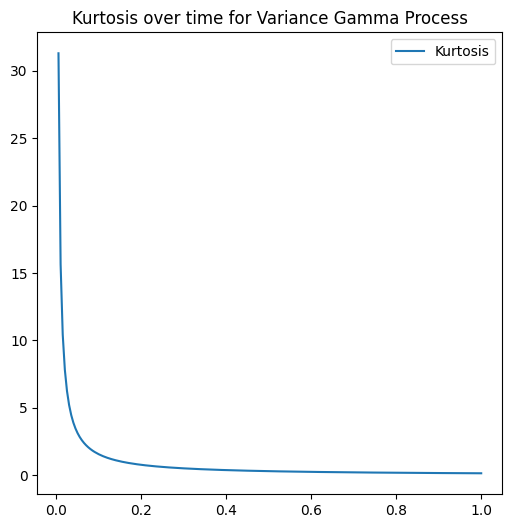

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Kurtosis over time for Variance Gamma Process')
plt.plot(t,moments[3], label='Kurtosis')
plt.legend(loc=0)

Text(0.5, 1.0, 'Variance Gamma Process: Variance')

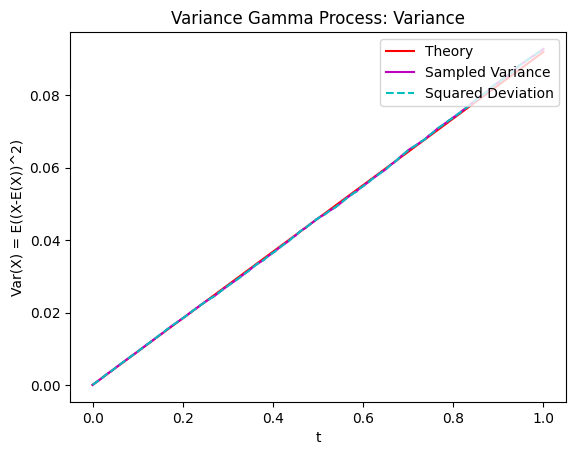

In [ ]:
# Variance = mean square deviation
plt.figure()
plt.plot(t, moments[1], 'r', label='Theory') 
plt.plot(t, np.var(X, axis=1), 'm', label='Sampled Variance')
plt.plot(t, np.mean((X - EX[:, np.newaxis])**2, axis=1), 'c--', label='Squared Deviation')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('Var(X) = E((X-E(X))^2)')
plt.title('Variance Gamma Process: Variance')

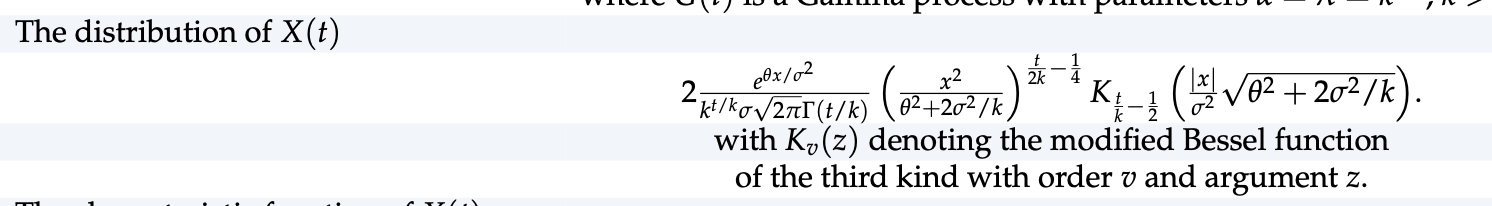

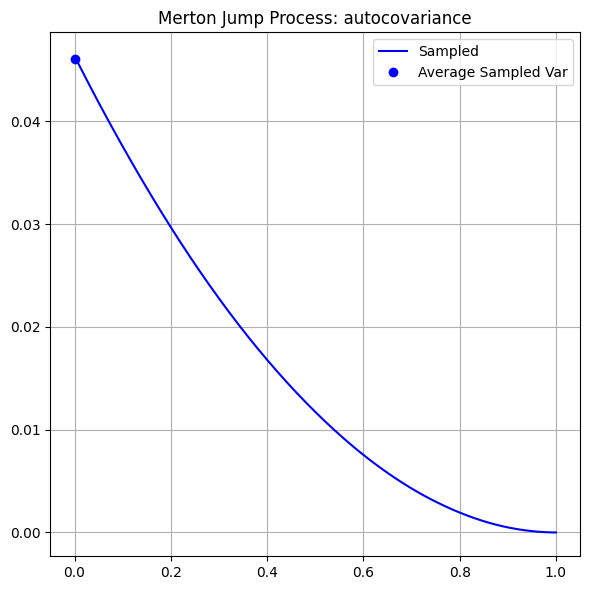

In [ ]:
from scipy.signal import correlate
# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = X[:, i] - EX
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps
# Average over all paths
C = np.mean(C, axis=0)

plt.figure(figsize=(6, 6))
t = np.linspace(0, T, nsteps+1)

# Plot theoretical autocovariance - sigma^2 / (2 * alpha) * exp(-alpha * t)
# plt.plot(t, (sigma**2 + lambda_val*(muJ**2+sigmaJ**2))*t, 'r', label='Theory') # WHAT IS s? It will always be smaller??

# Plot sampled autocovariance - plot second half since it's symmetric and the first half corresponds to negative lags
plt.plot(t, C[nsteps:], 'b', label='Sampled')
plt.plot(0, np.mean(np.var(X, axis=1)), 'bo', label='Average Sampled Var', linewidth=1.5) # average sampled variance

plt.legend(loc=0)
plt.title('Merton Jump Process: autocovariance')
plt.tight_layout()
plt.grid()

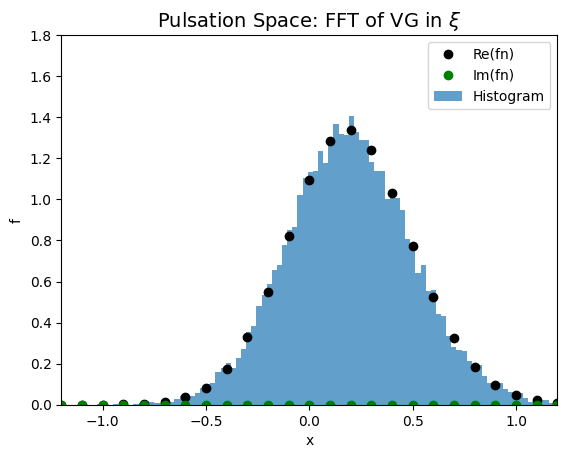

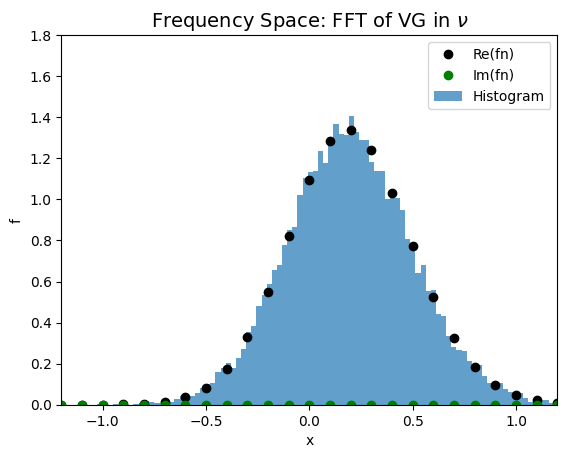

In [ ]:
# FFT to approx PDF using inverse FFT and characteristic function
# Parameters
npaths = 20000
T = 1
nsteps = 200
dt = T / nsteps
t = np.linspace(0, T, nsteps+1)
theta = 0.2
sigma = 0.3
kappa = 0.05

# Monte Carlo Simulation
dG = np.random.gamma(dt / kappa, kappa, size=(npaths, nsteps))
dX = theta * dG + sigma * np.sqrt(dG) * np.random.randn(npaths, nsteps)
X = np.concatenate([np.zeros((npaths, 1)), np.cumsum(dX, axis=1)], axis=1)

# FFT
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)
dxi = 2 * np.pi / (N * dx)
xi = dxi * np.arange(-N/2, N/2)
dnu = 1 / (N * dx)
nu = dnu * np.arange(-N/2, N/2)

# Pulsation space: xi
char_func = (1 - 1j * xi * theta * kappa + 0.5 * kappa * (xi * sigma)**2) ** (-T / kappa)
f_X = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(char_func))) / upperx

# Frequency space: nu
char_func1 = (1 - 1j * (2 * np.pi * nu) * theta * kappa + 0.5 * kappa * ((2 * np.pi * nu) * sigma)**2) ** (-T / kappa)
f_X1 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(char_func1))) / upperx

# Figures
plt.figure(1)
plt.plot(x, np.real(f_X), 'ko', linewidth=2)
plt.plot(x, np.imag(f_X), 'go')
plt.hist(X[:, -1], bins=100, density=True, alpha=0.7)
plt.axis([-1.2, 1.2, 0, 1.8])
plt.title('Pulsation Space: FFT of VG in $\\xi$', fontsize=14)
plt.xlabel('x')
plt.ylabel('f')
plt.legend(['Re(fn)', 'Im(fn)', 'Histogram'])

plt.figure(2)
plt.plot(x, np.real(f_X1), 'ko', linewidth=2)
plt.plot(x, np.imag(f_X1), 'go')
plt.hist(X[:, -1], bins=100, density=True, alpha=0.7)
plt.axis([-1.2, 1.2, 0, 1.8])
plt.title('Frequency Space: FFT of VG in $\\nu$', fontsize=14)
plt.xlabel('x')
plt.ylabel('f')
plt.legend(['Re(fn)', 'Im(fn)', 'Histogram'])

plt.show()
